In [8]:
import torch
import torchaudio
import mne
import torchaudio.functional as F
import torchaudio.transforms as T
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.preprocessing import RobustScaler, robust_scale

### Setup

In [21]:
# check the current working directory
cwd = '/Users/yeganeh/Codes/EEGNet/'
if os.getcwd() != cwd:
    os.chdir(cwd)

# channel names
EEG = mne.io.read_raw_brainvision('data/test/sub-032301/RSEEG/sub-010002.vhdr', eog=['VEOG'])
ch_names = EEG.info['ch_names']
ch_names.remove('VEOG')
del EEG

# helper function to load the data
# Helper functions
# clamp
def clamp_eeg(data, axis=1, deviation=20):
    """Clamp EEG data proportional to the standard deviation of each channel."""
    # container for clamped data
    data_clamped = np.zeros_like(data)
    upper_dev = data.mean(axis=axis) + data.std(axis=axis) * deviation
    lower_dev = data.mean(axis=axis) - data.std(axis=axis) * deviation
    for i in range(data.shape[0]):
        data_clamped[i, :] = np.clip(data[i, :], lower_dev[i], upper_dev[i])
    return data_clamped

def print_min_max(data, lower_dev, upper_dev, sub, channel):
    """Prints the min and max of a channel and checks if it would be clamped by the clamp_eeg function
    This is used to check if the clamp function is working as expected."""
    if data[sub, channel, :].min() < lower_dev[sub, channel] or data[sub, channel, :].max() > upper_dev[sub, channel]:
        print(f'Data: {sub}, {channel}: Min={data[sub, channel, :].min()}, Max={data[sub, channel, :].max()}',
              f'Bounderies: Lower={lower_dev[sub, channel]}, Higher={upper_dev[sub, channel]}')

def power_to_db(S, ref=1.0, amin=1e-10, top_db=80.0):
    ref_value = torch.tensor(ref)
    amin = torch.tensor(amin)
    log_spec = 10.0 * torch.log10(torch.maximum(amin, S))
    log_spec -= 10.0 * torch.log10(torch.maximum(amin, ref_value))

    if top_db is not None:
        if top_db < 0:
            raise ValueError("top_db must be non-negative")
        log_spec = torch.maximum(log_spec, log_spec.max() - top_db)

    return log_spec

Extracting parameters from data/test/sub-032301/RSEEG/sub-010002.vhdr...
Setting channel info structure...


### Preprocessing

In [ ]:
# load the data
data = xr.open_dataarray('data/baseline_corrected/eeg_EC_BaseCorr.nc5', engine='h5netcdf')
subjects = data.subject.values[:50]

# an xarray container for collecting procesed data across subjects
processed_data = {}

for sub in subjects:
  print(f'Processing {sub}')
  sub_data = data.sel(subject=sub).values

  # normalize
  sub_data = RobustScaler().fit_transform(sub_data)

  # clamp
  sub_data = clamp_eeg(sub_data)

  processed_data[sub] = sub_data

# save the processed data
data = xr.DataArray(np.array(list(processed_data.values())),
                    dims=('subject', 'channel', 'time'),
                    coords={'subject': list(processed_data.keys()),
                            'channel': ch_names})
# data.to_netcdf('data/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp_50.nc5')

### Feature extraction
#### time-frequency analysis

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


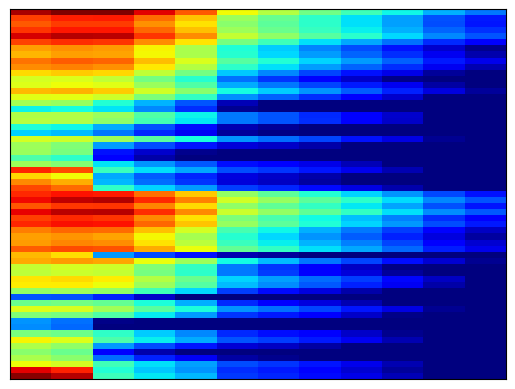

In [99]:
# open processed eeg data
data = xr.open_dataarray('data/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp_50.nc5', engine='h5netcdf')
subjects = data.subject.values

tfrs = {}

# morlet wavelet transform
freqs = np.arange(7, 30, 2) 
n_cycles = [np.ceil(i) for i in freqs/(freqs[0]-2)]

for sub in subjects:
    data = data.sel(subject=sub).values
    data = np.expand_dims(data, axis=0)  # add an additional dimension to the data
    tfr = mne.time_frequency.tfr_array_morlet(data, freqs=freqs, sfreq=128, n_cycles=n_cycles,
                                              output='power',
                                              n_jobs=-1)
    tfrs[sub] = tfr

# convert the dictionary to a xarray
tfrs = xr.DataArray(tfrs)
tfrs = tfrs.rename({'dim_0': 'subject', 'dim_1': 'frequency', 'dim_2': 'channel', 'dim_3': 'time'})
tfrs = tfrs.transpose('subject', 'frequency', 'channel', 'time')
tfrs.to_netcdf('data/tfrs.nc5')

# maybe only the spatial and frequency dimensions are important, so we can average over the time dimension
# and plot the heatmap of the average power over time (frequency X channels)
# Because our data is not time-locked!
tfr = tfr.squeeze().mean(axis=-1)
tfr = power_to_db(torch.tensor(tfr))

# plot heatmap of the average power over time (frequency x channels)
plt.imshow(tfr, aspect='auto', origin='lower', cmap='jet')
plt.xticks([])
plt.yticks([])
# plt.colorbar()

# save the plot
plt.savefig('data/figures/tfr_heatmap.png')

#### Plot topomap and use that as the input to the network

In [ ]:
# create a epochs object
info = mne.create_info(ch_names=ch_names, sfreq=128, ch_types='eeg')
epochs = mne.EpochsArray(data, info)

pos = mne.channels.make_standard_montage('standard_1005')
# add digitization points to the epoched data
epochs.set_montage(pos)
mne.viz.plot_tfr_topomap(tfr[0])